# Models
The general idea is to fit a model to the behavioural data of a subject, once only with information about the presented motion direction and criterion direction in each trial, the **experimental design (ED) model**, and once with an EEG-derived measure of the brain representation of the presented motion direction (together with the exact presented criterion direction), the **EEG model**. We then want to investigate whether the EEG model fits the behavioural data better than the ED model and the HDDM.

The ED model gets the actual value of the presented motion direction as a constant input. At every time step noise is added to this true motion direction and the ED model then integrates these noisy observations of motion direction to replicate variance in RT and choice for trials with the same true motion direction (and criterion). This is the basic mechanism which is also implemented in the DDM (if we were modelling motion direction judgements).

The EEG model gets *EEG channel responses*, one for each considered motion direction, as input. The channel responses are directly integrated as evidence for a particular motion direction. Through the noisiness of the EEG this model input carries its own source of variability. The main idea is that this variability in the EEG data explains a bit more of the variability of the behaviour than the completely random noise added in the ED model.

## Parameters
Following the above described mechanism the ED model has the following main parameters:
- `intstd`: subject's internal uncertainty about observations of motion direction, the higher,
  the slower and more accurate evidence accumulation should be
- `noisestd`: amount of noise added to motion direction observations; the higher, the faster and less accurate evidence accumulation should be
- `bound`: confidence bound that needs to be reached before subject makes a decision (typically 
  fixed to 0.7)
- `bias`: a response bias towards either clockwise or counter-clockwise choices
- `ndtloc`: log of lower bound of uniform non-decision time distribution; the lower, the smaller
  the non-decision time
- `lapseprob`: lapse probability, i.e. probability with which subject makes completely random
  choices with 0.5 choice probability and uniform RT distribution over the whole allowed range

The EEG model shares the same parameters. Following the description above the `noisestd` shouldn't be necessary. I still tested things allowing `noisestd > 0` which should have the effect that information in the EEG variability is washed out. This could be beneficial, when there are other signals in the EEG that are not relevant to the decision about motion direction. In tests with subject 18 I found that having `noisestd > 0` makes parts of the model unidentifiable (some correlation between noisestd and intstd in the posterior parameter distribution). I also found that fixing `noisestd = 0` leads to at least as good fit to the behaviour as having `noisestd` vary. I, therefore, fixed `noisestd = 0` in the EEG model for the inference on all subjects.

# Goodness of fit
To determine how well a model explains the behavioural data I use posterior predictive sampling. Specifically, inference with a model gives me a posterior parameter distribution for each subject that supposedly describes the behaviour of the subjects. I sample 2000 parameter sets from this distribution and then use the model to generate 2000 behavioural data sets for the trials of that subject. Then I can compare the sampled data sets to the observed one.

## Summary statistics
When inferring model parameters from data, I use summary statistics to compare sampled and observed data sets. The summary statistics I use are RT histograms: I use a fixed set of RT bins and then compute the fraction of clockwise responses falling into each bin separately for easy and hard trials. So these statistics summarise a data set of, e.g., 2000 trials as, in my case, 14 fractions. This is also how the DDM has typically been fit to data.

## Deviance
My comparison measure is a form of deviance or error, i.e., something based on the difference between sampled and observed. When $S$ is the number of samples from the posterior, $B$ the number of summary statistic bins, $\hat{f}_{s, b}$ is the fraction of clockwise responses in summary statistic bin $b$ of sample $s$ and $f_b$ is the fraction of clockwise responses in the observed data, my deviance measure is:
$$
D = \frac{1}{S}\sum_{s=1}^S \underset{b \in \{1,\dots,B\}}{\mathrm{median}}\left|\hat{f}_{s, b} - f_b\right|.
$$
Alternatively, we can replace the median above with the sum of squared errors and get a form of mean squared error:
$$
\mathrm{MSE} = \frac{1}{S}\sum_{s=1}^S \sum_{b=1}^B \left(\hat{f}_{s, b} - f_b\right)^2.
$$
The MSE equally summarises the goodness of fit across all summary statistic bins while D ignores large deviations in few bins.

# Results
In the following figure each vertical tick line represents the difference between goodness of fit for the indicated model and the EEG model for one subject. This means that positive values favour the EEG model in this subject and negative values the other model (because then the EEG model has larger D or MSE). The smooth lines are density estimates across subjects and indicate whether one model is better than the other on the group level. Additionally, I have added t-values of the hypothesis test for whether the shown values are different from 0 in the legends.

For the deviance D the EEG model tends to be better than the HDDM across subjects, but there is no evidence that the EEG model explains the behaviour of the subjects better than the ED model. For the MSE the trend is the same, but much less prominent, with models exhibiting more similar performance. The negative t-values for the MSE are driven by the two outlier subjects where the EEG model is clearly worse than the two other models.

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fit = pd.read_hdf('figures/goodness_of_fit.h5', 'fit')

<IPython.core.display.Javascript object>


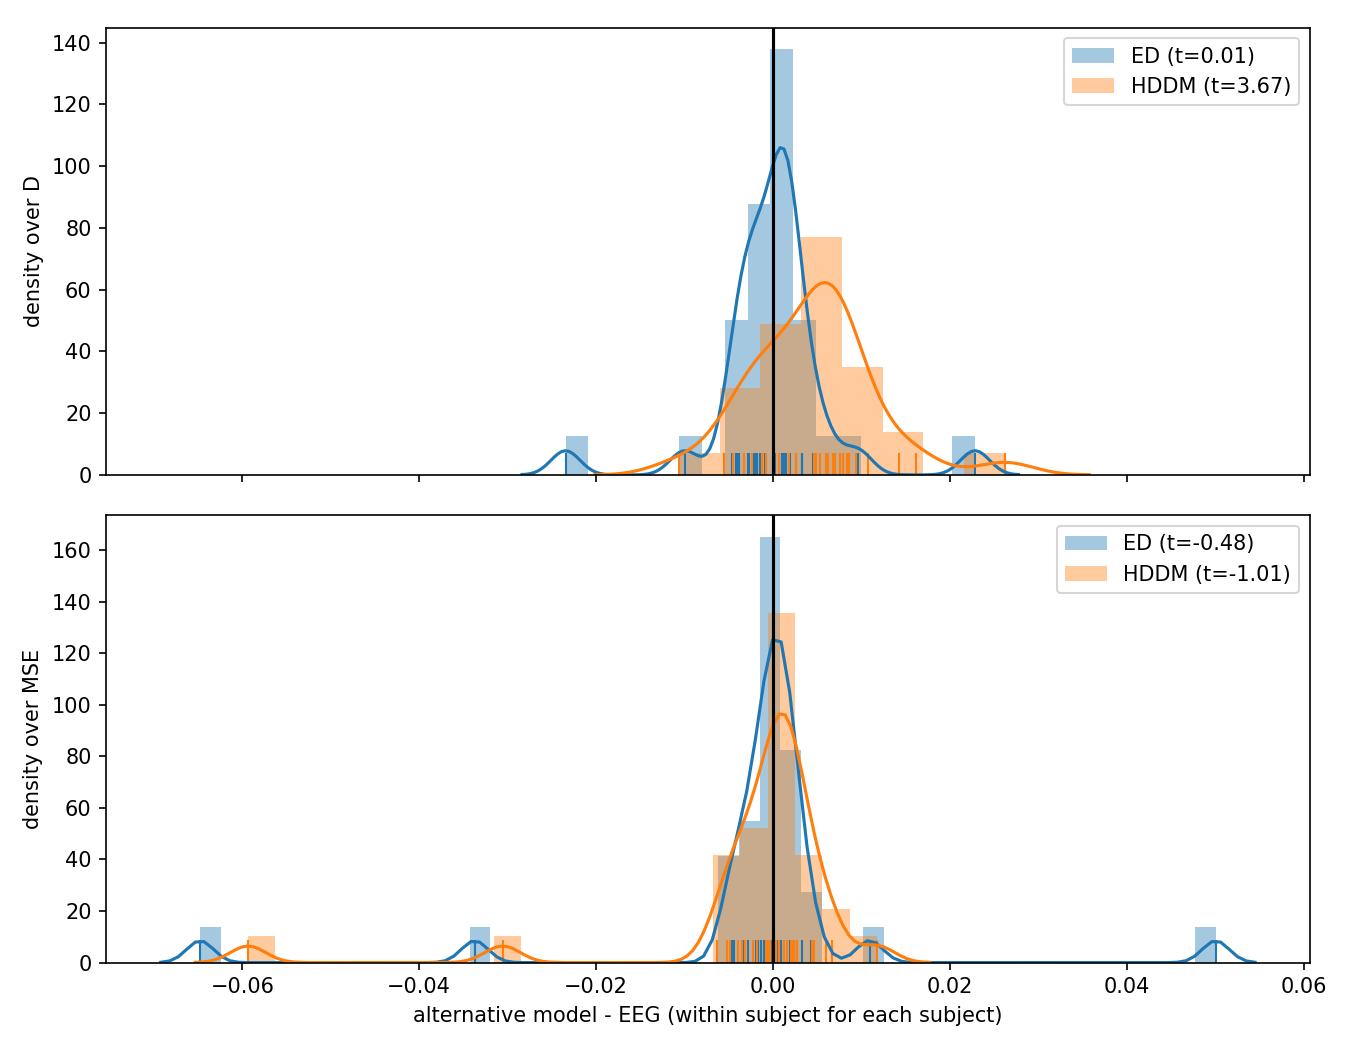

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

for ax, measure in zip(axes, ['D', 'MSE']):
    for model in ['ED', 'HDDM']:
        diffs = fit.loc[:, (measure, model)] - fit.loc[:, (measure, 'EEG')]
        tval = np.mean(diffs) / (np.std(diffs) / np.sqrt(len(diffs)))
        sns.distplot(diffs, label='{} (t={:.2f})'.format(model, tval), rug=True, ax=ax)
        
    ax.set_ylabel('density over {}'.format(measure))
    ax.legend()
    
for ax in axes:
    ax.set_autoscaley_on(False)
    ax.plot([0, 0], ax.get_ylim(), 'k')
    
ax.set_xlabel('alternative model - EEG (within subject for each subject)')
fig.tight_layout()